In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind


In [74]:
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [75]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

Cleaning the data. There are some nulls in the city and state columns which we will drop. the CTZ column is mostly null so those will be dropped as well

In [0]:
df.city.dropna(inplace=True)

In [77]:
df['40k'].isna().value_counts()

False    31984
Name: 40k, dtype: int64

In [0]:
df.drop(columns=['ctz'], inplace=True)

In [79]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', '35k', 'overall', 'pace', 'state', '30k', '5k', 'half',
       '20k', 'country', 'city', '40k'],
      dtype='object')

In [0]:
#Some of the times for marathon runs are not recorded. We will go ahead and remove these from the dataset.
df = df[df['5k']!='-']
df = df[df['10k']!='-']
df = df[df['25k']!='-']
df = df[df['30k']!='-']
df = df[df['35k']!='-']
df = df[df['40k']!='-']
df = df[df['half']!='-']

In [0]:
df.shape[0]
columns = ['5k', '10k', '25k', '30k', '35k', '40k', 'half']
for entry in columns:
  df[entry] = df[entry].astype('float')

In [82]:
df['5k'].dtypes

dtype('float64')

In [0]:
X=df[['5k','10k', '25k', '30k', '35k', '40k', 'half' ]]
Xnorm = normalize(X)


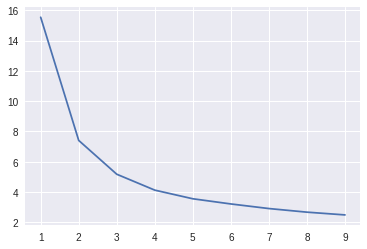

In [84]:
sse = {}
K = range(1,10)
for k in K:
  kmean = KMeans(n_clusters=k).fit(Xnorm)
  sse[k] = kmean.inertia_
  
plt.plot(list(sse.keys()), list(sse.values()))


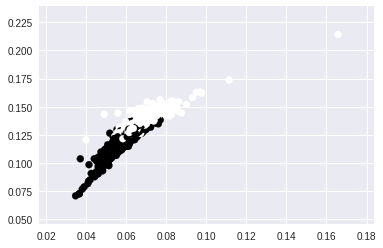

In [85]:
#it seems from the elbow graph that the ideal number of clusters is 2.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(Xnorm)
plt.scatter(Xnorm[:,0], Xnorm[:, 1], c=y_pred)
plt.show()


In [86]:
#Now that we have clustered the runners into 2 groups, we can see how those clusters compare to each other. First we'll do an inner join to get all the data
#together
dfy = pd.DataFrame(y_pred)
dfy.columns = ['cluster']
dfy.head()

,cluster
0,0
1,0
2,0
3,0
4,0


In [87]:
dfjoined = df.join(dfy, how='inner')
dfjoined.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,...,pace,state,30k,5k,half,20k,country,city,40k,cluster
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,...,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,0
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,...,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,0
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,...,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,0
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,...,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,0
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,...,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,0


In [88]:
dfjoined.groupby(dfjoined.cluster)['5k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,24.976163,27.134959
std,3.994891,4.279051
min,7.750000,8.680000
25%,22.120000,23.980000
50%,24.380000,26.980000
75%,27.220000,30.120000
max,51.980000,86.950000


In [89]:
dfjoined.groupby(dfjoined.cluster)['10k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,50.182225,54.622383
std,8.244775,8.854807
min,16.620000,18.300000
25%,44.320000,48.110000
50%,48.970000,54.070000
75%,54.770000,60.680000
max,102.820000,112.380000


In [90]:
dfjoined.groupby(dfjoined.cluster)['half'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,107.881739,118.114868
std,19.104872,20.924564
min,38.030000,43.170000
25%,94.520000,102.700000
50%,104.720000,115.820000
75%,117.570000,131.540000
max,236.670000,222.070000


In [91]:
dfjoined.groupby(dfjoined.cluster)['25k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,129.406417,142.241298
std,24.001578,26.489145
min,45.800000,52.900000
25%,112.730000,122.640000
50%,125.070000,138.920000
75%,141.170000,158.870000
max,289.020000,281.850000


In [92]:
dfjoined.groupby(dfjoined.cluster)['30k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,158.525681,175.042862
std,30.828175,34.169610
min,56.450000,67.120000
25%,137.130000,149.360000
50%,152.650000,170.120000
75%,173.450000,196.675000
max,367.200000,376.380000


In [93]:
dfjoined.groupby(dfjoined.cluster)['35k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,189.379670,209.859827
std,38.285666,42.247333
min,67.420000,81.770000
25%,162.980000,177.715000
50%,181.820000,203.470000
75%,208.320000,237.140000
max,439.820000,449.330000


In [94]:
dfjoined.groupby(dfjoined.cluster)['40k'].describe().transpose()


cluster,0,1
count,21773.000000,9563.000000
mean,220.367359,244.454448
std,45.279416,49.561433
min,76.100000,92.870000
25%,189.130000,206.110000
50%,211.370000,237.850000
75%,243.820000,277.210000
max,508.170000,508.350000


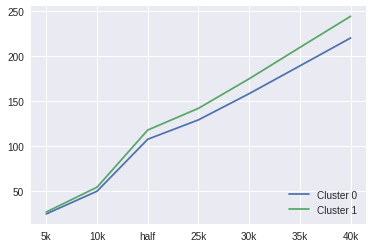

In [109]:
x=['5k', '10k', 'half', '25k', '30k', '35k', '40k']
y0=[]
y1=[]
for entry in x:
  y0.append(dfjoined[dfjoined.cluster==0][entry].mean())
  y1.append(dfjoined[dfjoined.cluster==1][entry].mean())
  
s = pd.Series(y0, index=x)
s1 = pd.Series(y1, index=x)
s.plot(kind='line', rot=0,label='Cluster 0')
s1.plot(kind='line', rot=0, label='Cluster 1')
plt.legend(loc='lower right')
plt.xticks(index, x)
plt.show()

Conclusion: It seems that the runners in cluster 0 are significantly faster runners in all categories.